# Individualized iRF for the enhancer data
For a particular data unit, collect all the paths on which this particular unit falls and look for the intersections.


### load packages

In [1]:
require('iRF')
require('dplyr')
require('mclust')
require('perm')
require('ggplot2')

Loading required package: iRF
iRF 2.0.0
Loading required package: dplyr

Attaching package: ‘dplyr’

The following object is masked from ‘package:iRF’:

    combine

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: mclust
Package 'mclust' version 5.4
Type 'citation("mclust")' for citing this R package in publications.
Loading required package: perm
Loading required package: ggplot2

Attaching package: ‘ggplot2’

The following object is masked from ‘package:iRF’:

    margin



### load the data

In [2]:
load('./individual_enhancer.RData')
load('./enhancer.Rdata')

### set figure size

In [3]:
options(repr.plot.width = 4, repr.plot.height=4)

### predefined functions 

In [4]:
index2names <- function(strs, name.list) {
    # change a integer string to meaningful names
    #  for example, change "45 64" to "Kr Twi"
    if (length(strs) > 0 && class(strs[0]) == 'factor') {
        strs = as.character(strs)
    }
    return(strs %>% strsplit(' ') %>%
    lapply(FUN = as.numeric) %>%
    lapply(FUN = function(x) name.list[x]) %>%
    sapply(FUN = function(x) paste(x, collapse = ' ')))
}
multi.modality.test <- function(data) {
    if (length(data) < 50) {
        return(NA)
    }
    # return the log.likelihood ratio between 2 Gaussian mixitures and 1 Gaussian
    log.likelihood2 <- Mclust(data, G = 2, verbose = F)$loglik
    log.likelihood1 <- Mclust(data, G = 1, verbose = F)$loglik
    return((log.likelihood2 - log.likelihood1)/length(data))
}

pretty_gene <- function(strs) {
    tmp_list <- strsplit(strs, ' ')[[1]]
    for (i in 1:length(tmp_list)) {
        tmp1 <- gsub('[[:digit:]]+', '', tmp_list[i])
        tmp2 <- gsub('^[A-z]*_', '', tmp1)
        tmp_list[i] <- paste(toupper(substring(tmp2, 1, 1)), substring(tmp2, 2), collapse = '', sep = '')
     
    }
    return(paste(tmp_list, collapse = ' ', sep = ''))
}

## Individualized iRF 
- For each sample, select all the RF paths that it falls into and transform them into boolean vectors showing what features are splitted.
- Find their intersections with high prevalence.
- Currently, the intersections are found using apriori (exact method) with prevalence larger than .1

## Result analysis

We can get the intersection for each data unit, the output is a data frame with two columns:

In [5]:
out.list[[1]] %>% mutate(Interaction = index2names(Interaction, varnames.all[[1]])) %>% tail

Interaction               Prevalence
480 wt_ZLD bcd2 gt2 kr1 twi1  0.110     
481 wt_ZLD bcd2 kr1 twi1 twi2 0.110     
482 bcd2 gt2 kr1 twi1 twi2    0.130     
483 wt_ZLD bcd2 gt2 kr1 twi2  0.126     
484 wt_ZLD bcd2 gt2 twi1 twi2 0.172     
485 wt_ZLD gt2 kr1 twi1 twi2  0.166

As we get the intersections for each data unit, we collect all the prevalences for each intersections and investigate into its distribution patterns.

In [6]:
interaction.freq = list()
for (out in out.list) {
  out$Interaction <- as.character(out$Interaction)
  for (row.index in 1:nrow(out)) {
    comb <- out$Interaction[row.index]
    if (comb %in% names(interaction.freq)) {
      interaction.freq[[comb]] = c(interaction.freq[[comb]], out$Prevalence[row.index])
    } else {
      interaction.freq[[comb]] = c(out$Prevalence[row.index])
    }
  }
}

In [7]:
sprintf('The number of interactions is %d', length(interaction.freq))

[1] "The number of interactions is 3104"

## ranking of interactions by overall prevalence

# A tibble: 10 x 2
   interaction overall_prevalence
   <chr>                    <dbl>
 1 Gt Twi                   0.739
 2 Gt Kr                    0.557
 3 Kr Twi                   0.554
 4 ZLD Gt                   0.546
 5 ZLD Twi                  0.522
 6 Gt Kr Twi                0.473
 7 ZLD Gt Twi               0.456
 8 ZLD Kr                   0.401
 9 Bcd Gt                   0.361
10 Ca Gt                    0.350


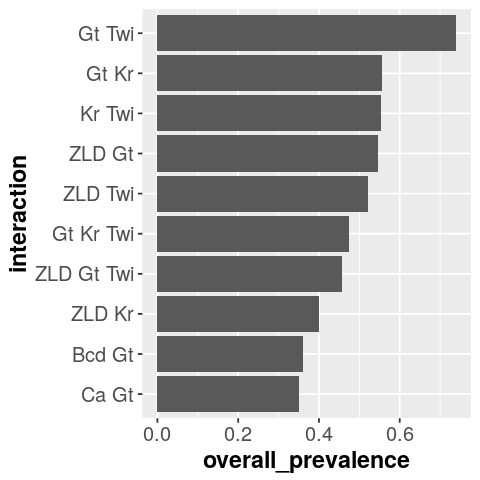

In [8]:
tmp = unlist(lapply(interaction.freq, function(x) sum(x) / length(train.id)))
names(tmp) <- as.character(names(tmp))
data1 <- data.frame(index = as.character(names(tmp)), 
                    interaction = index2names(names(tmp), varnames.all[[1]]),
                    overall_prevalence = unlist(tmp))

data1$interaction = as.character(data1$interaction)
for (i in 1:nrow(data1)) {
    data1$interaction[i] <- pretty_gene(as.character(data1$interaction[i]))
    if (grepl('Twi Twi', data1$interaction[i])) {
        data1$overall_prevalence[i] = 0
    }
}

head_table <- data1 %>% filter(nchar(as.character(index)) > 3) %>% group_by(interaction) %>% 
    summarise(overall_prevalence = max(overall_prevalence)) %>% 
        arrange(desc(overall_prevalence)) %>% head(n = 10) 
print(head_table)
head_table$interaction = factor(head_table$interaction, levels = rev(as.character(head_table$interaction)))


#head(head_table)
head_table %>% group_by(interaction) %>% summarise(overall_prevalence = max(overall_prevalence)) %>%
    ggplot() + geom_bar(aes(x = interaction, y = overall_prevalence), stat = 'identity')+coord_flip()+
    theme(axis.text=element_text(size=12),        axis.title=element_text(size=14,face="bold"))

### Interesting multi-modality pattern in 'wt_ZLD gt2 kr1'
The histogram of 'wt_ZLD gt2 kr1' exhibits a clear two-modality pattern. It means for some samples this interaction is not that often while for some other samples this interaction becomes very important for classification.

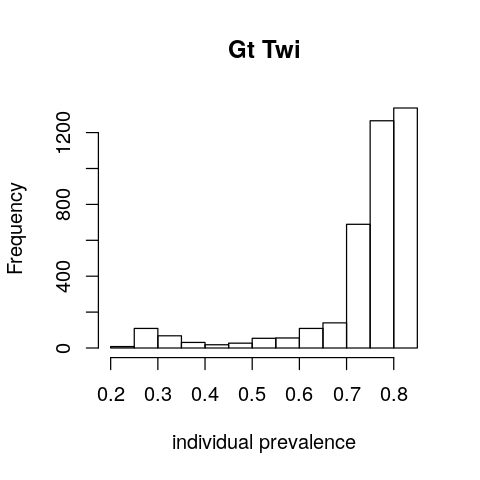

In [9]:
to_investigate = '54 79'
hist(interaction.freq[[to_investigate]], main = pretty_gene(index2names(to_investigate, varnames.all[[1]])), xlab = 'individual prevalence') 

### Why there are two clusters? 
It might be because of the clusters in the data

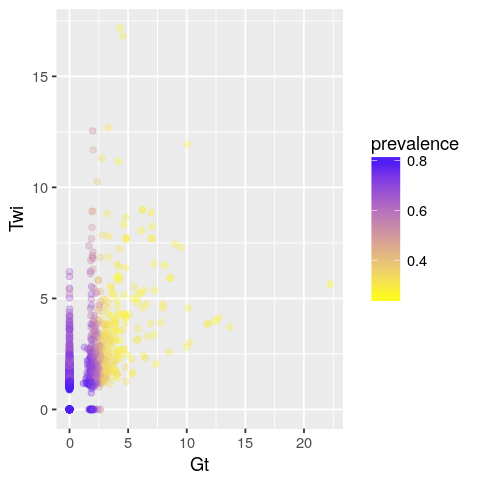

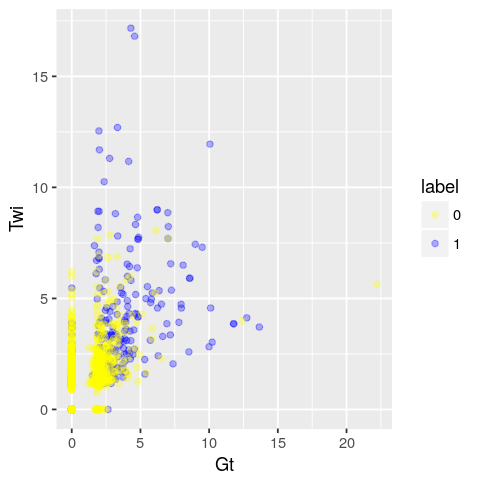

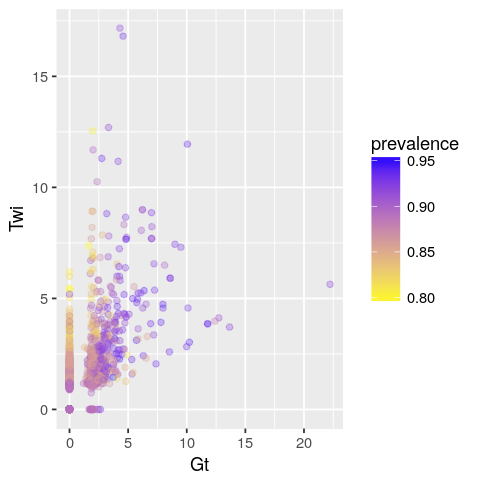

In [10]:
indices <- which(sapply(out.list, function(x) to_investigate %in% x$Interaction))
tmp <- interaction.freq[[to_investigate]] >= .4
group1 <- train.id[indices[tmp]]
group0 <- train.id[interaction.freq[[to_investigate]] < .4]
X1 <- X[group1,]
X0 <- X[group0,]
#plot(colMeans(X1))
#plot(colMeans(X0))
# mean difference over standard deviation
#plot((colMeans(X1) - colMeans(X0))/apply(X[train.id[indices],], 2, sd))
#which(colMeans(X1) - colMeans(X0) < -30)
ggplot(data = data.frame(Gt = X[train.id[indices],54], Twi = X[train.id[indices],79], prevalence = interaction.freq[[to_investigate]])) +
    geom_point(aes(x = Gt, y = Twi, colour = prevalence), alpha = .3)+scale_color_gradient(low="yellow", high="blue") 

ggplot(data = data.frame(Gt = X[train.id[indices],54], Twi = X[train.id[indices],79], label = as.factor(Y[train.id[indices]]))) +
    geom_point(aes(x = Gt, y = Twi, colour = label), alpha = .3)+scale_colour_manual(values = c("yellow", "blue") )

ggplot(data = data.frame(Gt = X[train.id,54], Twi = X[train.id,79], prevalence = interaction.freq[['54']])) +
    geom_point(aes(x = Gt, y = Twi, colour = prevalence), alpha = .3)+scale_color_gradient(low="yellow", high="blue") 


### What are the frequent feature interactions for the upper right cluster?

  0   1 
368 202 
   0    1 
3196  146 
[1] 570


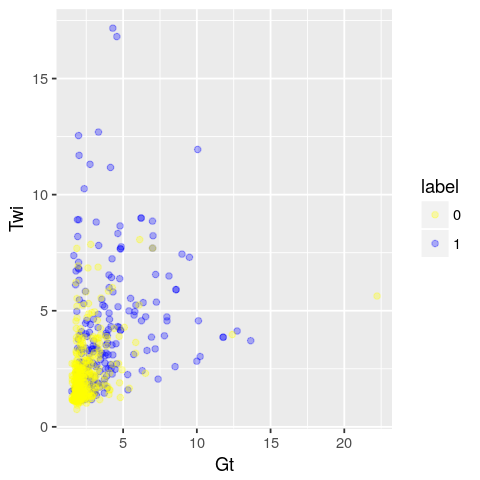

In [11]:
new_cluster1 <- indices[X[train.id[indices],54] > 1.5 & X[train.id[indices],79] > .5]
print(summary(as.factor(Y[train.id[new_cluster1]])))
print(summary(as.factor(Y[train.id[-new_cluster1]])))
#new_cluster1 <- indices[interaction.freq[['54 79']] < .4]
print(length(new_cluster1))
ggplot(data = data.frame(Gt = X[train.id[new_cluster1],54], 
                         Twi = X[train.id[new_cluster1],79], 
                         label = as.factor(Y[train.id[new_cluster1]]))) +
    geom_point(aes(x = Gt, y = Twi, colour = label), alpha = .3)+scale_colour_manual(values = c("yellow", "blue")) 


### Train a RF and find out!

In [17]:
n.cores = 1
rit.params <- list(depth=5, nchild=2, ntree=500, class.id=1, class.cut=NULL, local = F, min.nd = 1)
new_cluster_test <- X[test.id,54] > 1.5 & X[test.id,79] > .5
fit <-  iRF(x=X[train.id[new_cluster1],], 
           y=as.factor(Y[train.id[new_cluster1]]),
           xtest=X[test.id[new_cluster_test],],
           ytest=as.factor(Y[test.id[new_cluster_test]]),
           n.iter=3,
           interactions.return=c(1, 3),
           rit.params=rit.params,
           varnames.grp=varnames.all$Predictor_collapsed,
           n.core=n.cores,
           n.bootstrap=3,
           rit.param=rit.params
          )

[1] "iteration =  1"
[1] "AUROC:  0.81"
[1] "iteration =  2"
[1] "AUROC:  0.82"
[1] "iteration =  3"
[1] "AUROC:  0.81"
finding interactions ... finding interactions ... 

In [18]:
fit$interaction

[[1]]
         bcd_da2          bcd_gt2          cad1_kr           da2_kr 
       1.0000000        1.0000000        1.0000000        1.0000000 
          gt2_hb          gt2_hkb          gt2_kni           gt2_kr 
       1.0000000        1.0000000        1.0000000        1.0000000 
         gt2_twi        H3_wt_ZLD      H3K18ac_gt2       H3K18ac_kr 
       1.0000000        1.0000000        1.0000000        1.0000000 
     H3K18ac_twi   H3K18ac_wt_ZLD      H3K27me3_kr      H3K36me3_hb 
       1.0000000        1.0000000        1.0000000        1.0000000 
     H3K36me3_kr     H3K36me3_twi      H3K4me3_gt2        H3K9ac_kr 
       1.0000000        1.0000000        1.0000000        1.0000000 
           hb_kr           kni_kr           kr_twi       wt_ZLD_bcd 
       1.0000000        1.0000000        1.0000000        1.0000000 
      wt_ZLD_gt2        wt_ZLD_hb        wt_ZLD_kr       wt_ZLD_twi 
       1.0000000        1.0000000        1.0000000        1.0000000 
        bcd_cad1           bcd_hb          bcd_kni           bcd_kr 
       0.6666667        0.6666667        0.6666667        0.6666667 
         bcd_twi         cad1_gt2           D1_gt2           D1_twi 
       0.6666667        0.6666667        0.6666667        0.6666667 
         da2_gt2           da2_hb           dl3_kr         gt2_med2 
       0.6666667        0.6666667        0.6666667        0.6666667 
            h_hb             h_kr            H3_kr       H3K27ac_kr 
       0.6666667        0.6666667        0.6666667        0.6666667 
    H3K36me3_gt2      H3K4me1_da2       H3K4me1_kr       H3K4me3_kr 
       0.6666667        0.6666667        0.6666667        0.6666667 
     H3K4me3_twi   H3K4me3_wt_ZLD       H4K5ac_gt2          hb_med2 
       0.6666667        0.6666667        0.6666667        0.6666667 
          hb_twi          kni_twi          kr_med2        prdFQ_twi 
       0.6666667        0.6666667        0.6666667        0.6666667 
       wt_H3_twi      wt_ZLD_cad1       wt_ZLD_kni           bcd_D1 
       0.6666667        0.6666667        0.6666667        0.3333333 
         bcd_dl3         bcd_ftz3         bcd_med2          cad1_D1 
       0.3333333        0.3333333        0.3333333        0.3333333 
          cad1_h         cad1_kni        cad1_med2         cad1_twi 
       0.3333333        0.3333333        0.3333333        0.3333333 
           D1_hb            D1_kr          da2_dl3          ftz3_hb 
       0.3333333        0.3333333        0.3333333        0.3333333 
      ftz3_prdBQ            gt2_h        gt2_prdBQ          gt2_sna 
       0.3333333        0.3333333        0.3333333        0.3333333 
         gt2_tll           H3_bcd           H3_gt2      H3_H3K36me3 
       0.3333333        0.3333333        0.3333333        0.3333333 
          H3_twi            H3_z2      H3K18ac_da2      H3K18ac_dl3 
       0.3333333        0.3333333        0.3333333        0.3333333 
H3K18ac_H3K27me3 H3K18ac_H3K36me3       H3K18ac_hb      H3K18ac_kni 
       0.3333333        0.3333333        0.3333333        0.3333333 
     H3K18ac_tll      H3K27ac_twi    H3K27ac_wt_H3   H3K27ac_wt_ZLD 
       0.3333333        0.3333333        0.3333333        0.3333333 
    H3K27me3_bcd     H3K27me3_gt2      H3K27me3_hb    H3K27me3_med2 
       0.3333333        0.3333333        0.3333333        0.3333333 
    H3K27me3_run     H3K27me3_sna     H3K27me3_twi     H3K36me3_bcd 
       0.3333333        0.3333333        0.3333333        0.3333333 
   H3K36me3_cad1     H3K36me3_da2  H3K36me3_H3K9ac     H3K36me3_kni 
       0.3333333        0.3333333        0.3333333        0.3333333 
    H3K36me3_tll  H3K36me3_wt_ZLD      H3K4me1_bcd     H3K4me1_ftz3 
       0.3333333        0.3333333        0.3333333        0.3333333 
     H3K4me1_gt2      H3K4me1_kni    H3K4me1_prdBQ      H3K4me1_sna 
       0.3333333        0.3333333        0.3333333        0.3333333 
     H3K4me1_tll      H3K4me1_twi      H3K4me3_bcd   H3K4me3_H4K8ac 
       0.3333333        0.3333333        0.3333333        0.3

### The result is very different from original iRF result and is not stable (haven't calculated their stability score)

[1] 34468    80


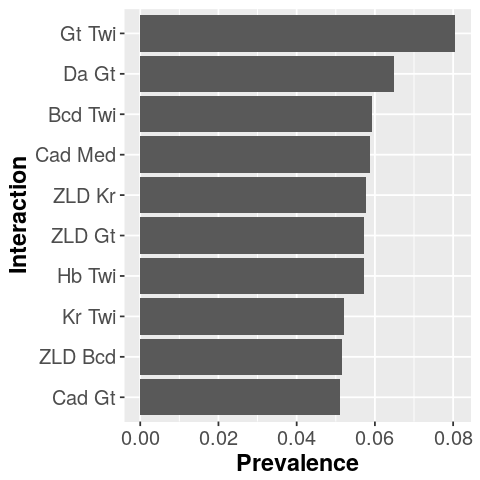

In [136]:
paths <- tmp$node.feature
print(dim(paths))
out <- RIT(paths, depth = 5, n_trees = 2000)#, weights = apply(tmp$node.obs[,new_cluster1], 2, mean))
head_table <- out%>% mutate(Interaction = sapply(index2names(Interaction, varnames.all[[2]]), pretty_gene)) %>% head(n = 10) 
head_table$Interaction = factor(head_table$Interaction, levels = rev(as.character(head_table$Interaction)))
head_table %>%
ggplot() + geom_bar(aes(x = Interaction, y = Prevalence), stat = 'identity')+coord_flip()+
    theme(axis.text=element_text(size=12),        axis.title=element_text(size=14,face="bold"))

# Appendix: Historical codes

[1] "factor"

      index    interaction overall_prevalence
1     46 54     wt_ZLD gt2         0.02628119
2     54 64        gt2 kr1         0.02302454
3     54 79       gt2 twi2         0.01664008
4     54 65        gt2 kr2         0.01375102
5     54 67       gt2 med2         0.01310020
6     48 54       bcd2 gt2         0.01306544
7     46 64     wt_ZLD kr1         0.01177198
8  46 54 64 wt_ZLD gt2 kr1         0.01109867
9     54 57        gt2 hb1         0.01101738
10    54 78       gt2 twi1         0.01040695


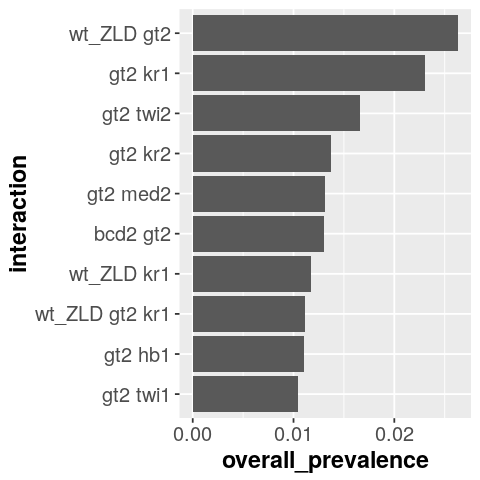

In [73]:
new.freq = list()
for (i in 1:length(out.list)) {
  if (i %in% new_cluster2) {
    out = out.list[[i]]
    out$Interaction <- as.character(out$Interaction)
    for (row.index in 1:nrow(out)) {
      comb <- out$Interaction[row.index]
      if (comb %in% names(new.freq)) {
        new.freq[[comb]] = c(new.freq[[comb]], out$Prevalence[row.index])
      } else {
        new.freq[[comb]] = c(out$Prevalence[row.index])
      }
    }
  }
}

tmp = unlist(lapply(new.freq, function(x) sum(x) / length(train.id)))
names(tmp) <- as.character(names(tmp))
data1 <- data.frame(index = as.character(names(tmp)), 
                    interaction = index2names(names(tmp), varnames.all[[1]]),
                    overall_prevalence = unlist(tmp))
class(data1$index)
head_table <- data1 %>% filter(nchar(as.character(index)) > 3) %>% 
    arrange(desc(overall_prevalence)) %>% head(n = 10) 
head_table$interaction = factor(head_table$interaction, levels = rev(as.character(head_table$interaction)))
print(head_table)
    
head_table %>% ggplot() + geom_bar(aes(x = interaction, y = overall_prevalence), stat = 'identity')+coord_flip()+
    theme(axis.text=element_text(size=12),        axis.title=element_text(size=14,face="bold"))

In [37]:
irf.output <- fit
ind <- length(irf.output$rf.list)
rf.last <- readForest(irf.output$rf.list[[ind]], x=X[train.id,], return.node.obs=TRUE)
ids <- apply(rf.last$node.obs[,-new_cluster1], FUN = any, MARGIN = 1)
tmp <- subsetReadForest(rf.last, ids)

ERROR: Error in readForest(irf.output$rf.list[[ind]], x = X[train.id, ], return.node.obs = TRUE): No Forest component in the randomForest object


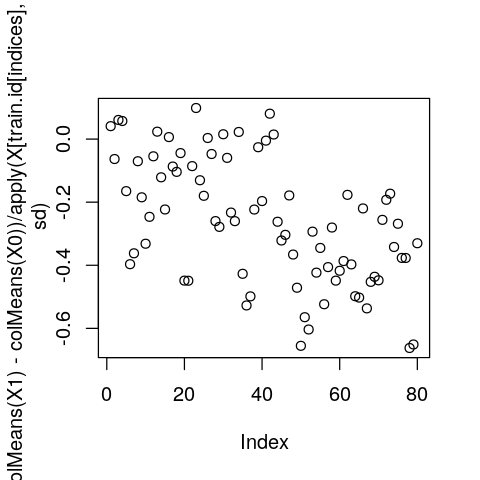

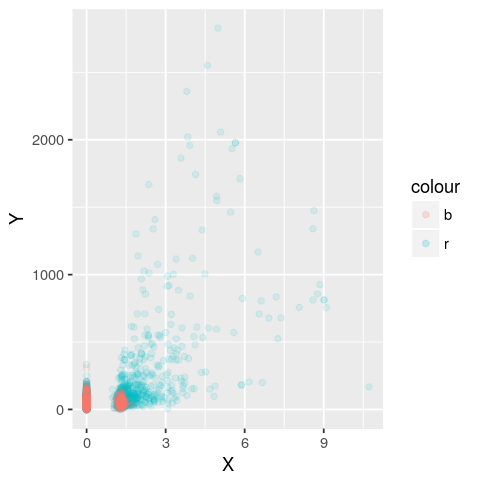

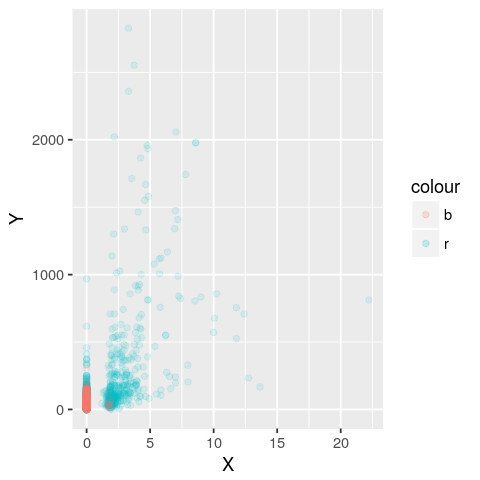

Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Transformation introduced infinite values in continuous x-axis”`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 25 rows containing non-finite values (stat_bin).”`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 11 rows containing non-finite values (stat_bin).”

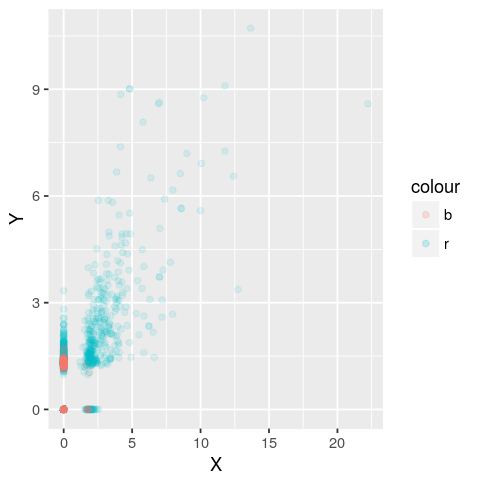

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


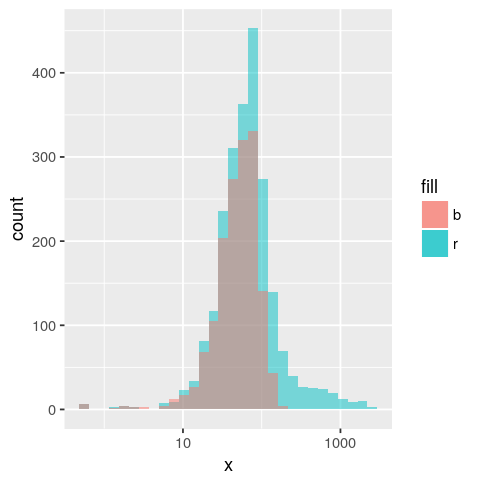

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


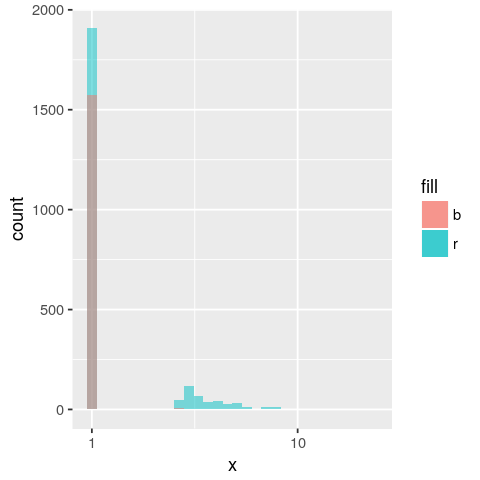

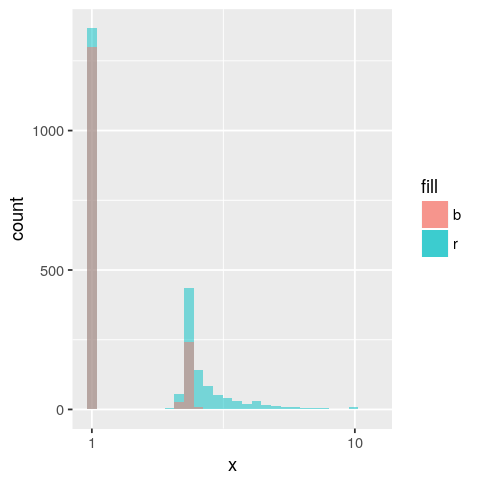

In [99]:
    #scale_fill_gradientn(colours = terrain.colors(30))

ggplot() + geom_point(data = data.frame(X = X0[,64], Y = X0[,46]), aes(x = X, y = Y, colour = 'r'), alpha = .1) +
    geom_point(data = data.frame(X = X1[,64], Y = X1[,46]), aes(x = X, y = Y, colour = 'b'), alpha = .1)

ggplot() + geom_point(data = data.frame(X = X0[,54], Y = X0[,46]), aes(x = X, y = Y, colour = 'r'), alpha = .1) +
    geom_point(data = data.frame(X = X1[,54], Y = X1[,46]), aes(x = X, y = Y, colour = 'b'), alpha = .1)

ggplot() + geom_point(data = data.frame(X = X0[,54], Y = X0[,64]), aes(x = X, y = Y, colour = 'r'), alpha = .1) +
    geom_point(data = data.frame(X = X1[,54], Y = X1[,64]), aes(x = X, y = Y, colour = 'b'), alpha = .1)

    ggplot() + geom_histogram(data = data.frame(x = X0[, 46]), aes(x = x, fill =  'r'), alpha = .5) +
    geom_histogram(data = data.frame(x = X1[, 46]), aes(x = x, fill = 'b'), alpha = .5) + scale_x_log10()

ggplot() + geom_histogram(data = data.frame(x = X0[, 54]+1), aes(x = x, fill =  'r'), alpha = .5) +
    geom_histogram(data = data.frame(x = X1[, 54]+1), aes(x = x, fill = 'b'), alpha = .5) + scale_x_log10()

ggplot() + geom_histogram(data = data.frame(x = X0[, 64]+1), aes(x = x, fill =  'r'), alpha = .5) +
    geom_histogram(data = data.frame(x = X1[, 64]+1), aes(x = x, fill = 'b'), alpha = .5) + scale_x_log10()
#boxplot(X0[,34], X1[, 34])

### save the intermediate result

In [84]:
save.image('intermediate_results.Rdata')

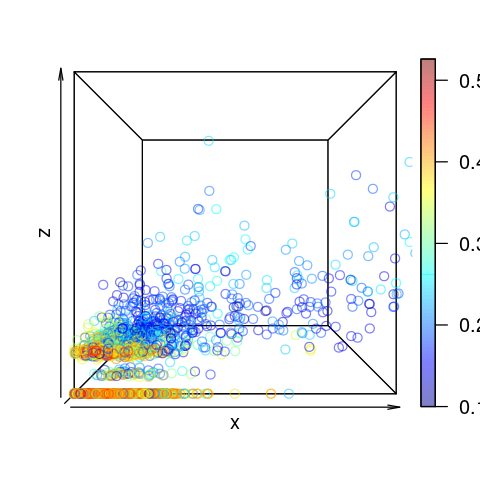

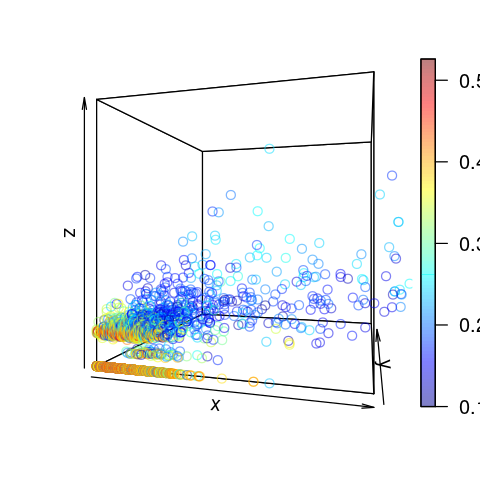

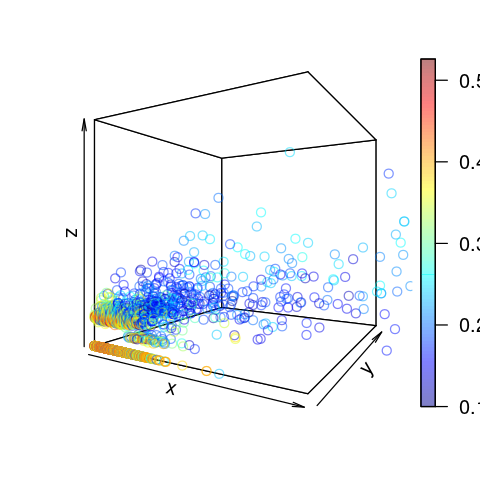

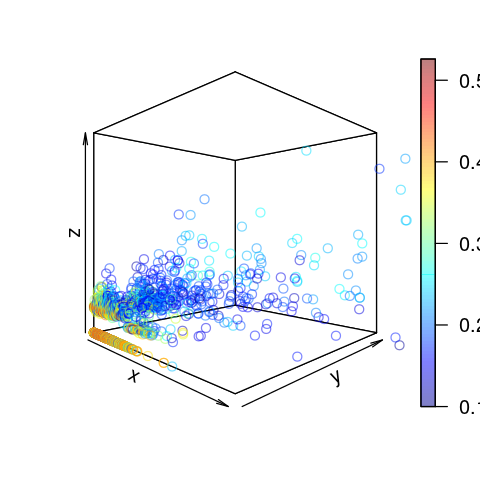

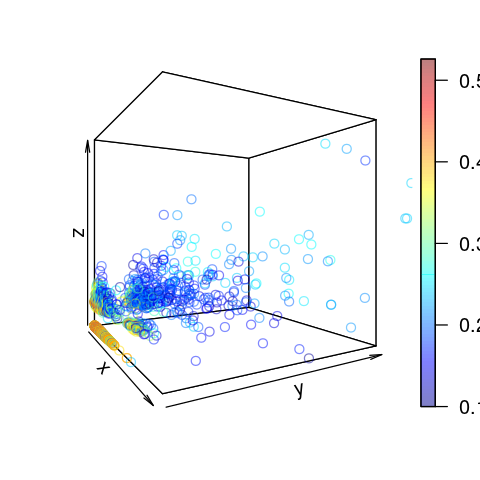

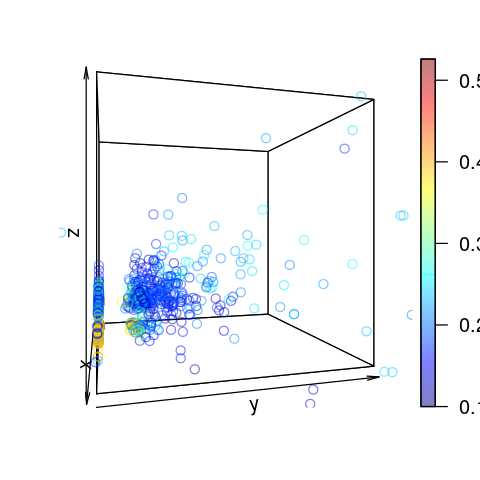

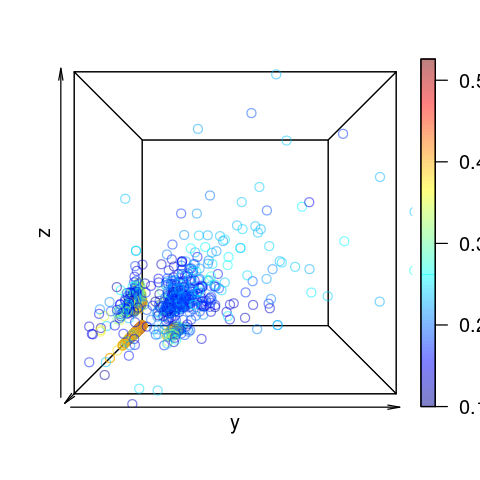

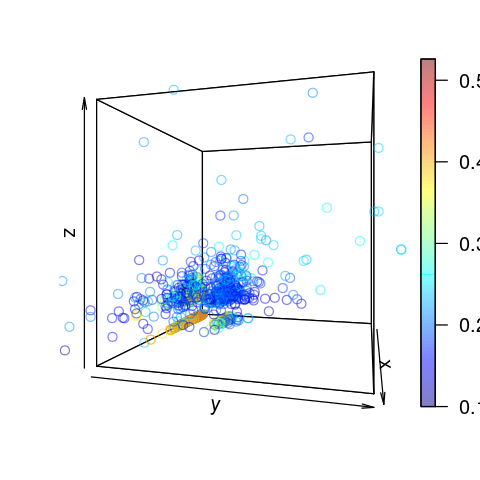

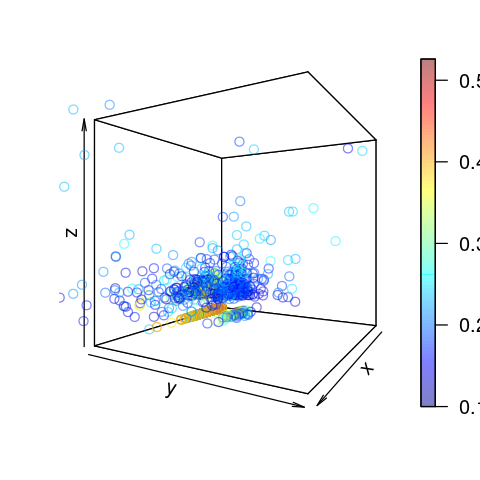

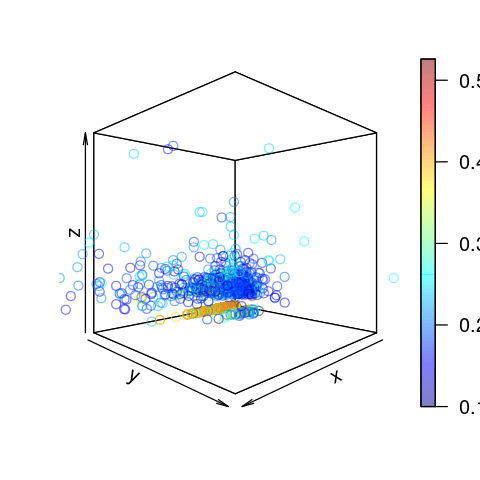

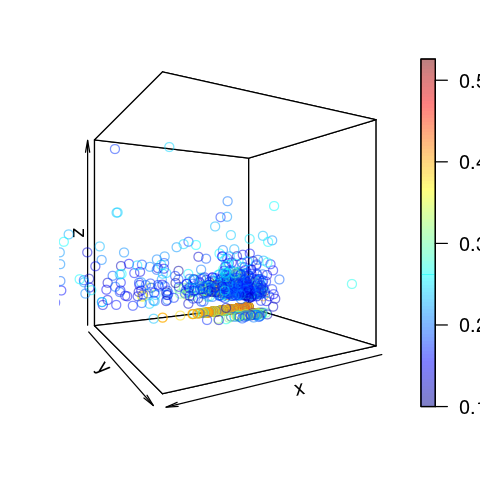

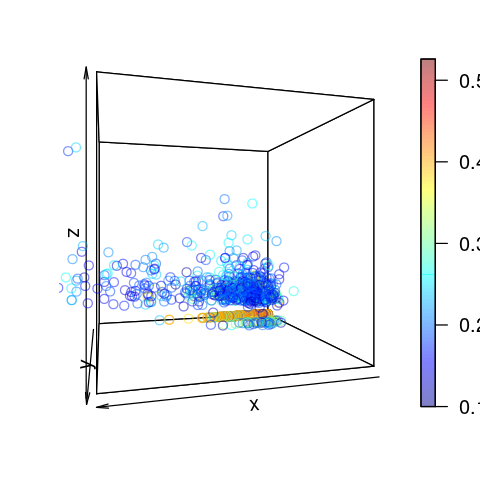

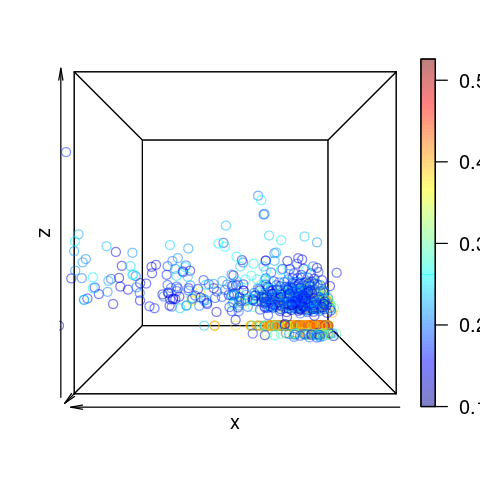

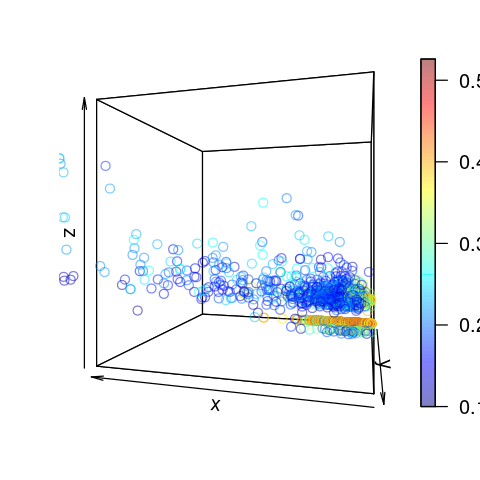

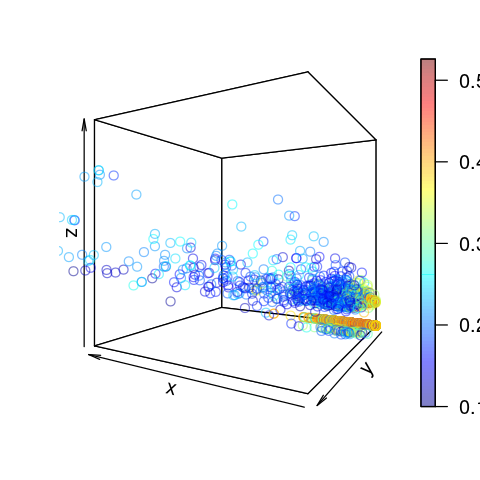

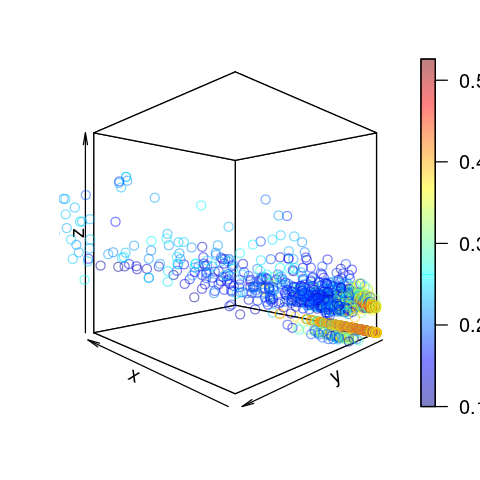

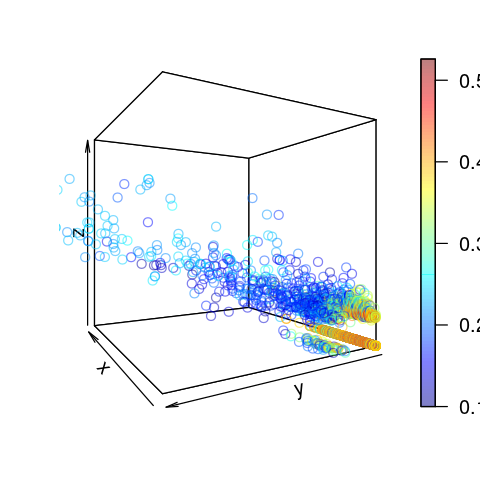

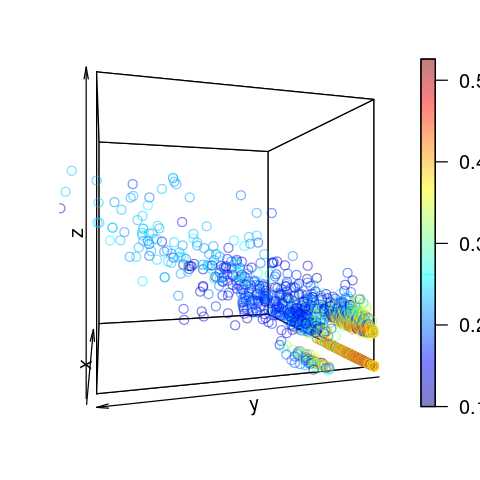

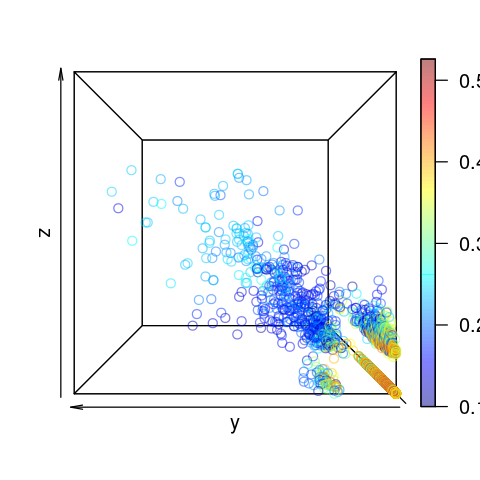

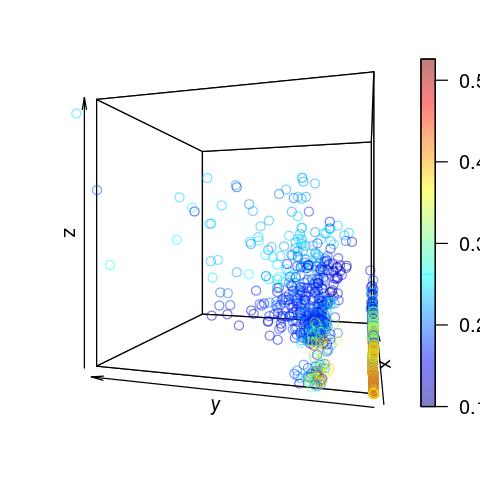

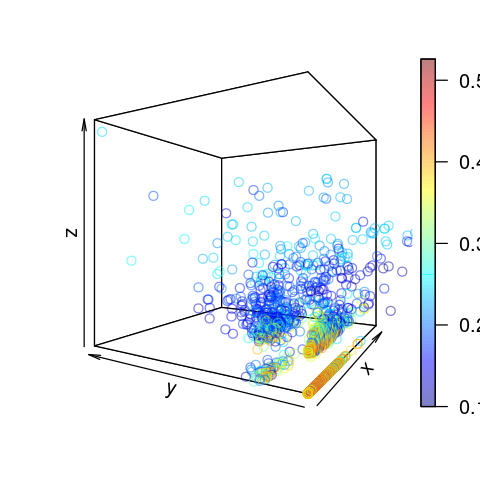

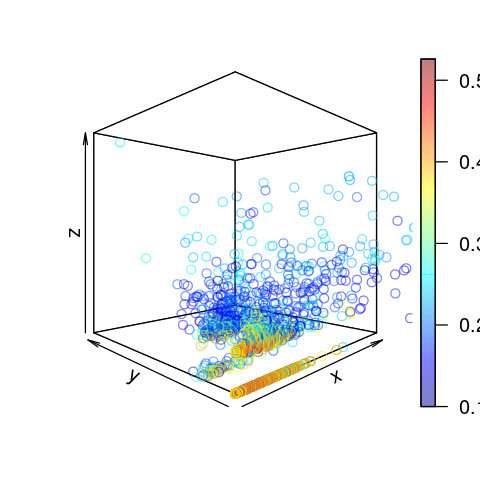

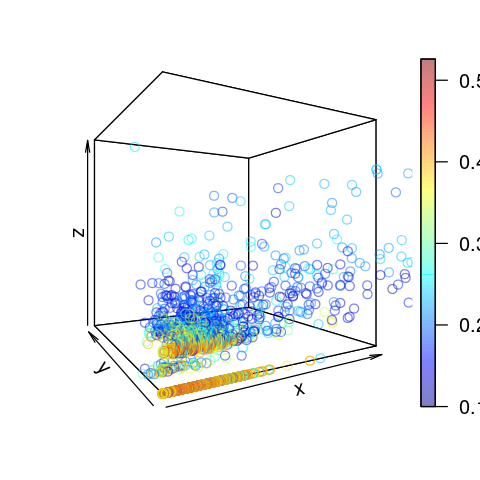

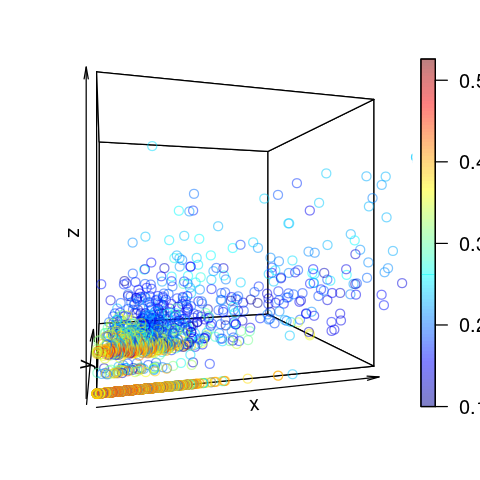

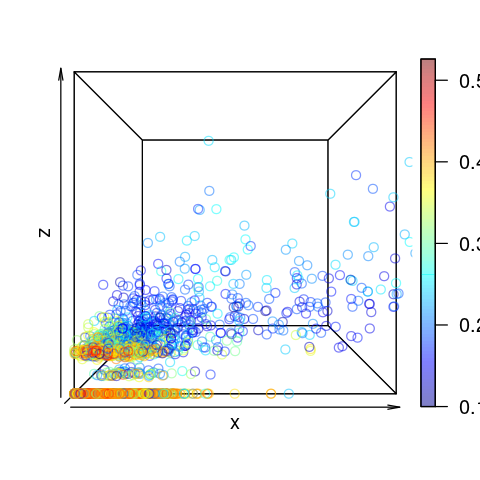

In [83]:
require('plot3D')
angle = 0
for (angle in seq(0, 360, by = 15)) {
#scatter3D(X0[,46],X0[,54],X0[,64], phi = 0, theta = angle, xlim = c(0, 500), ylim = c(0, 10), zlim = c(0, 10), colvar = Y[group0])
#scatter3D(X1[,46],X1[,54],X1[,64], phi = 0, theta = angle, xlim = c(0, 500), ylim = c(0, 10), zlim = c(0, 10), colvar = Y[group1])
scatter3D(X[train.id[indices],46],X[train.id[indices],54],X[train.id[indices],64],
          xlim = c(0, 500), ylim = c(0, 10), zlim = c(0, 10), alpha = 0.5,
          phi = 0, theta = angle, colvar = interaction.freq[[to_investigate]])
}

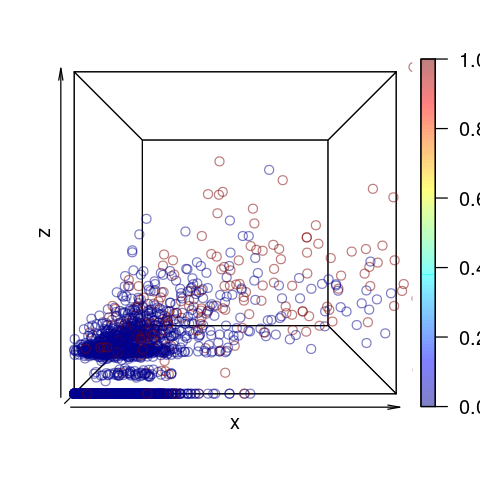

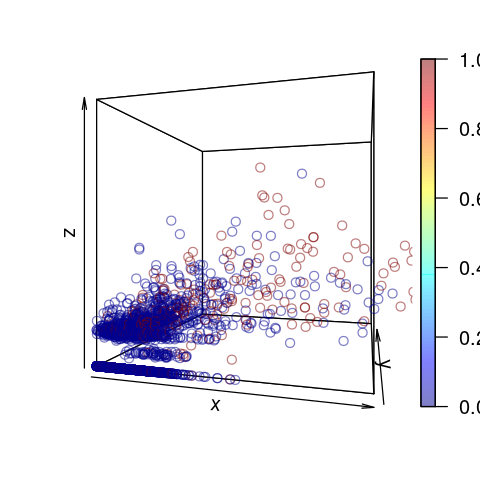

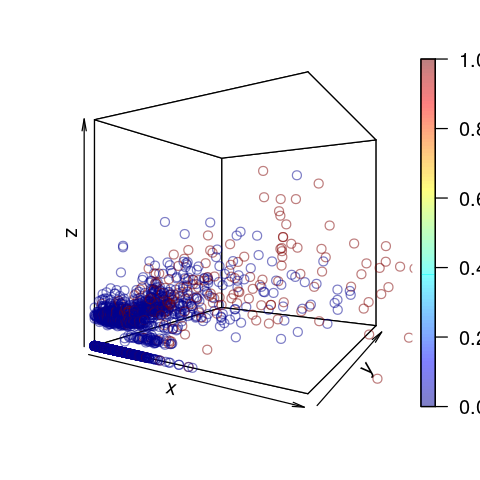

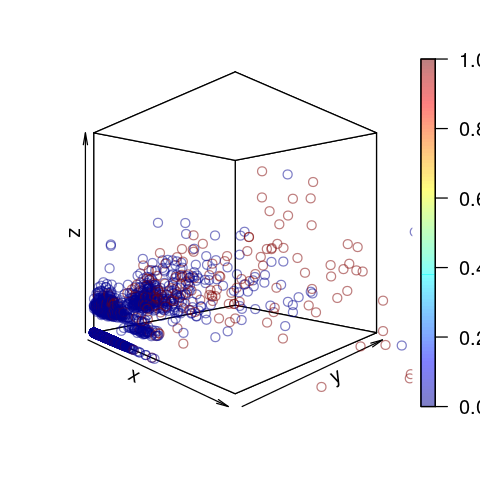

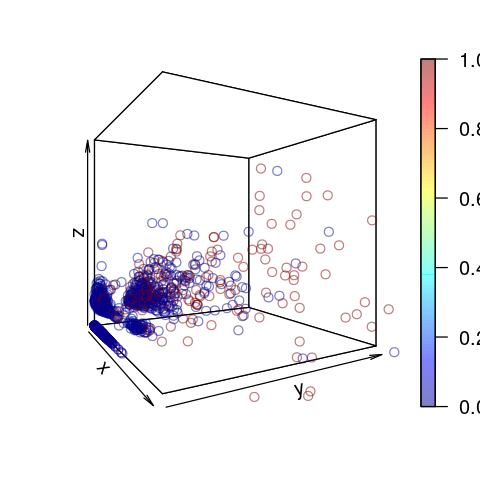

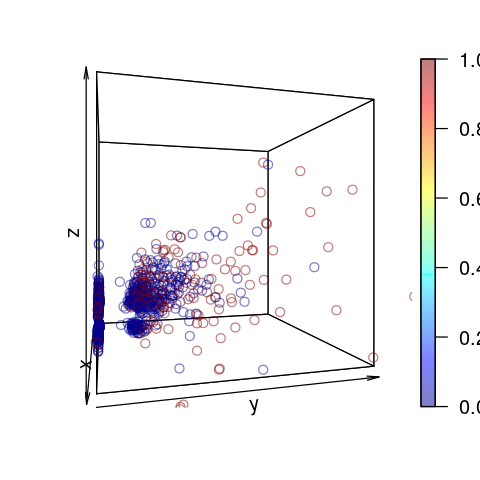

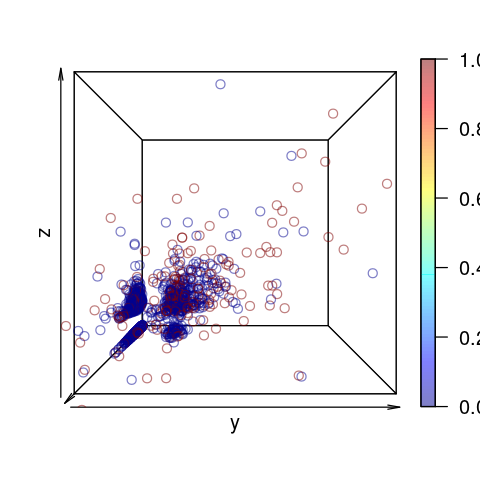

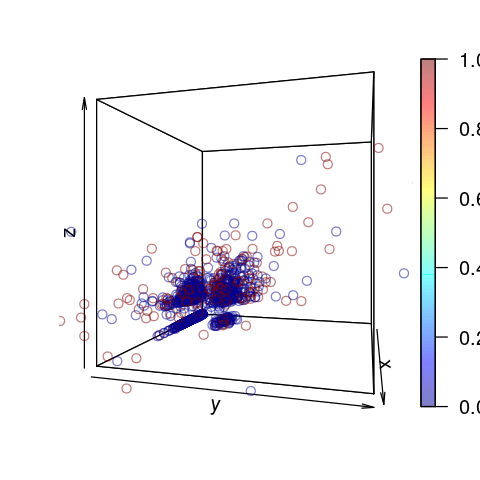

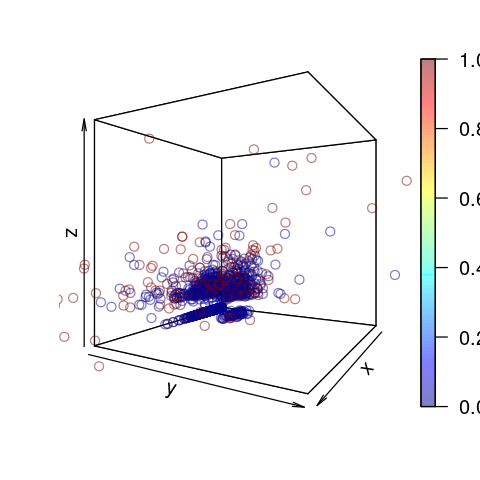

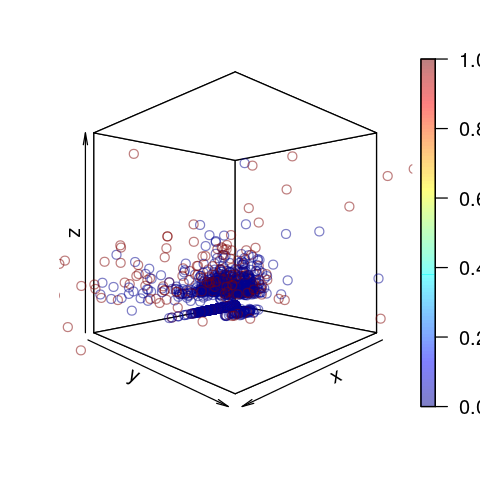

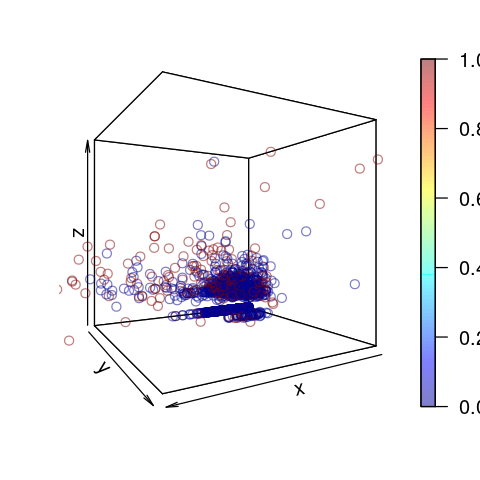

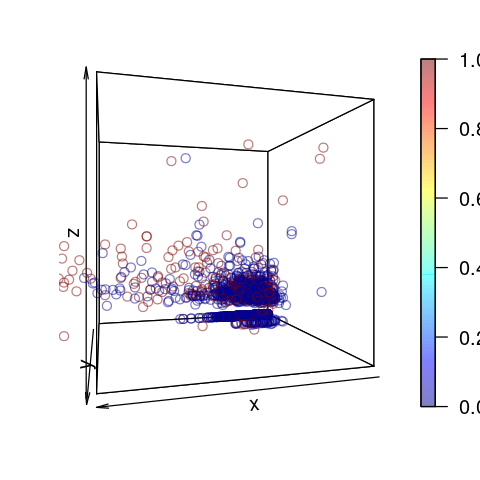

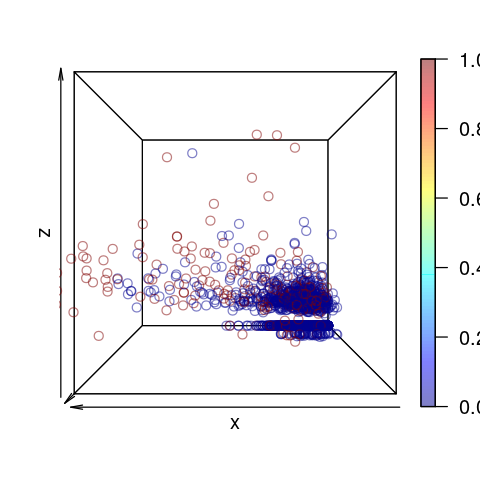

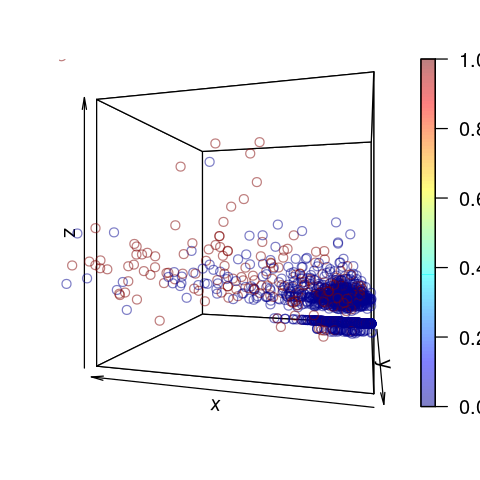

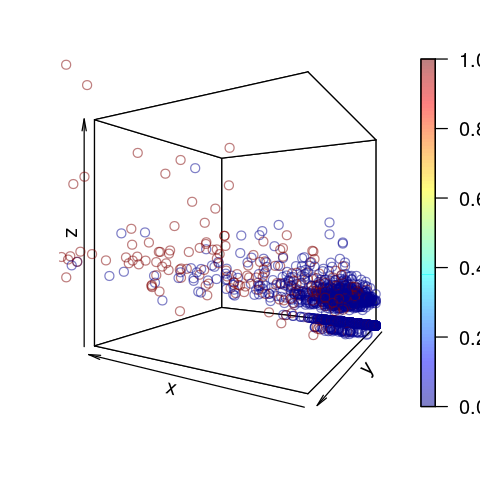

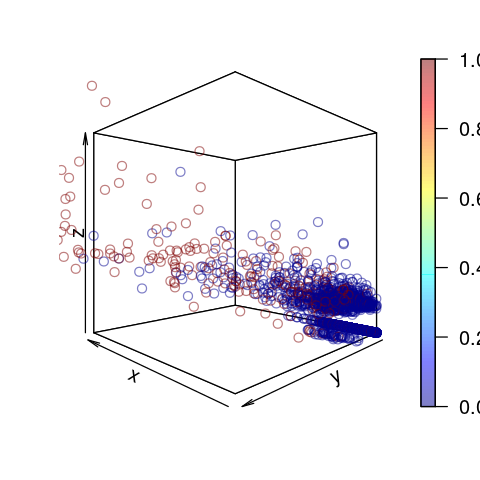

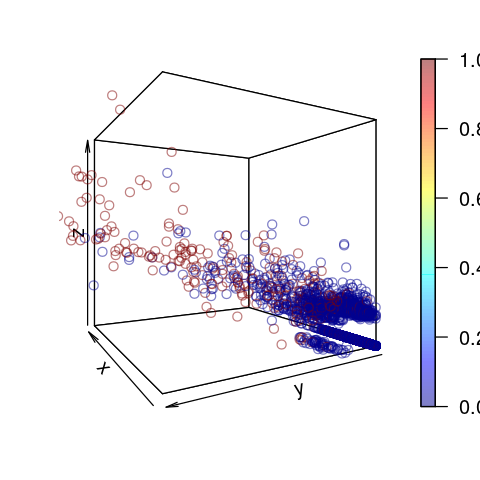

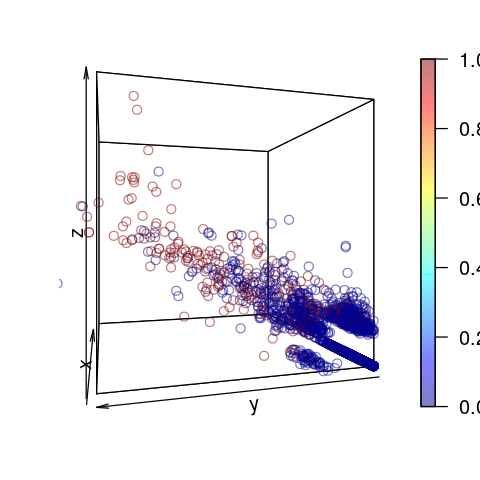

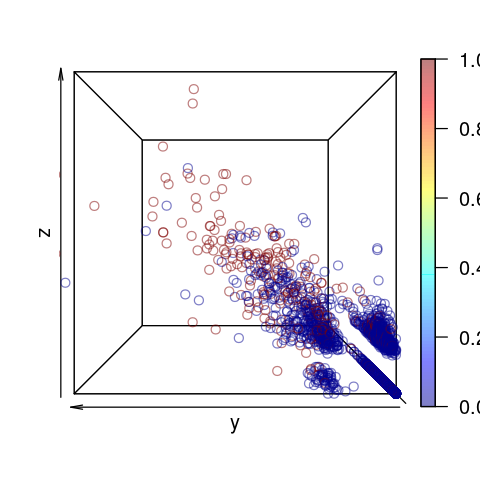

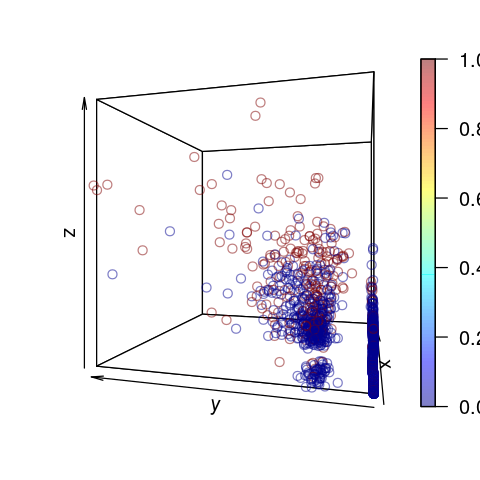

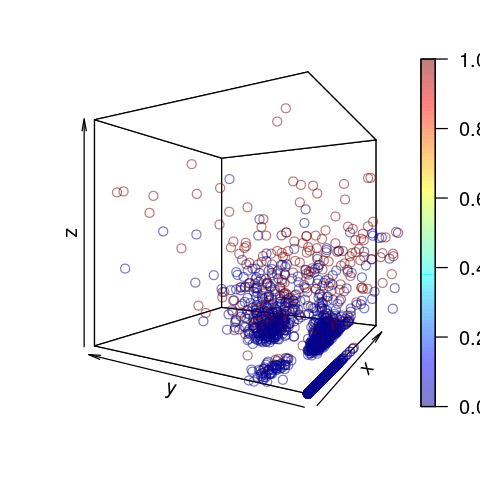

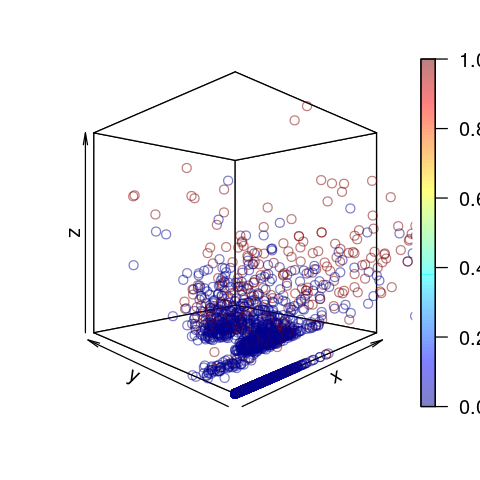

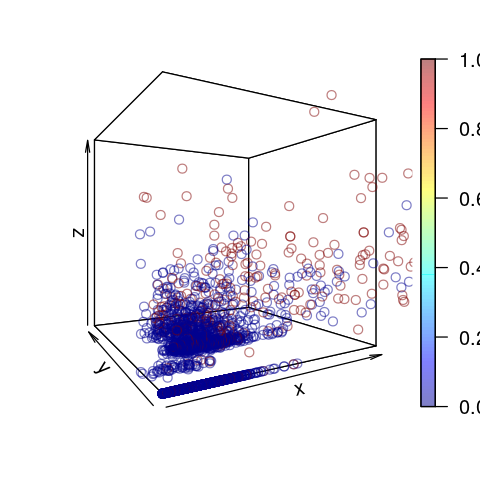

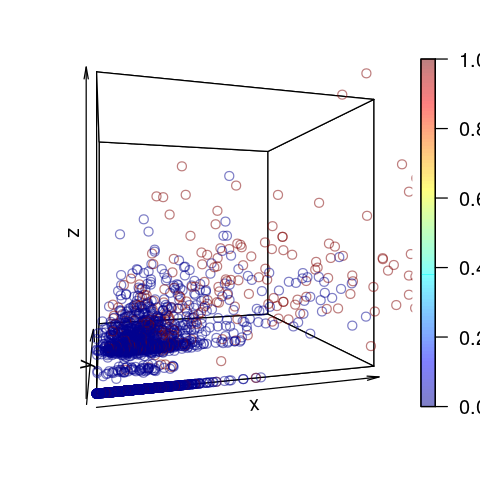

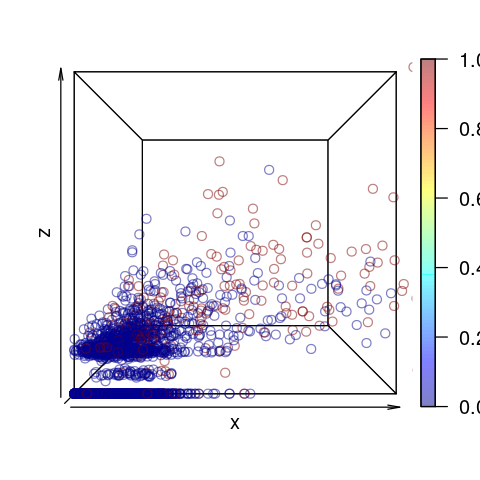

In [65]:
for (angle in seq(0, 360, by = 15)) {
#scatter3D(X0[,46],X0[,54],X0[,64], phi = 0, theta = angle, xlim = c(0, 500), ylim = c(0, 10), zlim = c(0, 10), colvar = Y[group0])
#scatter3D(X1[,46],X1[,54],X1[,64], phi = 0, theta = angle, xlim = c(0, 500), ylim = c(0, 10), zlim = c(0, 10), colvar = Y[group1])
scatter3D(X[test.id,46],X[test.id,54],X[test.id,64],
          xlim = c(0, 500), ylim = c(0, 10), zlim = c(0, 10), alpha = 0.5,
          phi = 0, theta = angle, colvar = Y[test.id])
}

### Look into different features that two populations are different.

In [85]:
# TODO: the previous result seems wrong because almost all the features are significantly different for this two population.

### investigate other interactions that has multi-modality
Multi-modality is measured by a **likelihood ratio** between Gaussian with 2 mixuters and Gaussian with 1 mixiture.

In [136]:
#multi.modality.test(interaction.freq[[2933]])
#print((interaction.freq[[2933]]))
#tmp = c()
#for (i in 1:length(interaction.freq)) {
#    tmp[i] = multi.modality.test(interaction.freq[[i]])
#    print(i)
#}
tmp <- lapply(interaction.freq, function(x) multi.modality.test(x))
tmp <- unlist(tmp)

In [137]:
# find the maximum value in tmp
max(tmp, na.rm = T)

[1] 0.8492656

In [141]:
data.frame(Interaction = index2names(names(tmp[tmp > .6]), varnames.all[[1]]), 
           Indices = names(tmp[tmp > .6]),
           Score = unlist(tmp[tmp > .6], use.names = F)) %>% filter(!is.na(Indices)) %>% arrange(desc(Score))

Interaction      Indices     Score    
1  gt2 twi1         54 78       0.8492656
2  H4K5ac_c14a gt2  32 54       0.7381370
3  D1 gt2 twi1      50 54 78    0.7161464
4  D1 gt2           50 54       0.6816733
5  bcd2 med2 twi2   48 67 79    0.6726211
6  dl3 gt2          52 54       0.6680071
7  gt2 twi2         54 79       0.6667649
8  wt_ZLD D1 gt2    46 50 54    0.6412222
9  D1 twi1          50 78       0.6308009
10 dl3 twi2         52 79       0.6164722
11 twi2             79          0.6102172
12 D1 gt2 twi1 twi2 50 54 78 79 0.6009544

### Multi-modality gives some meaningful interactions
'wt_ZLD gt2 kr1' appears in the list. Let's take a look at the other distributions

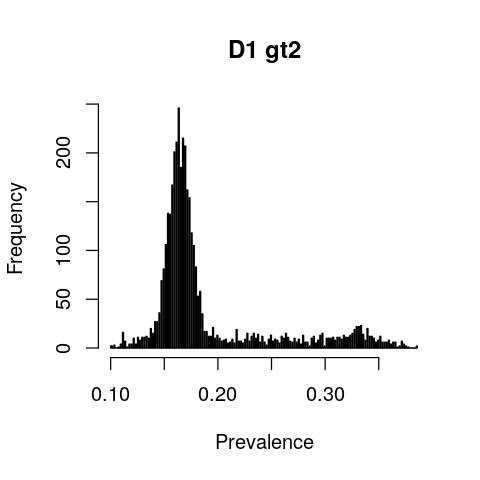

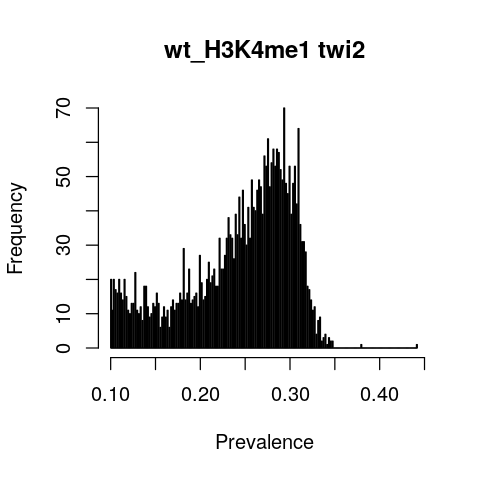

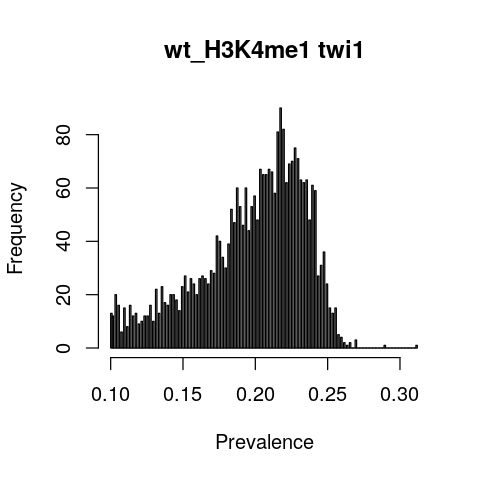

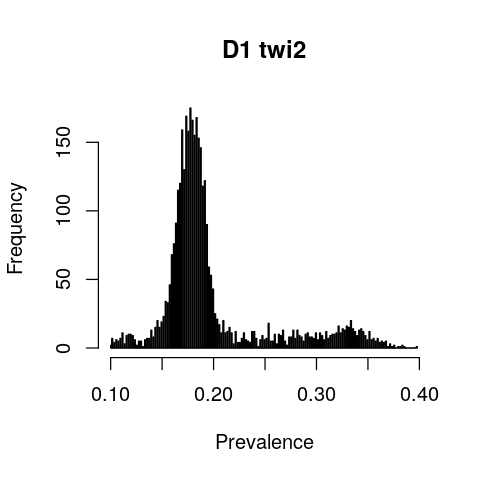

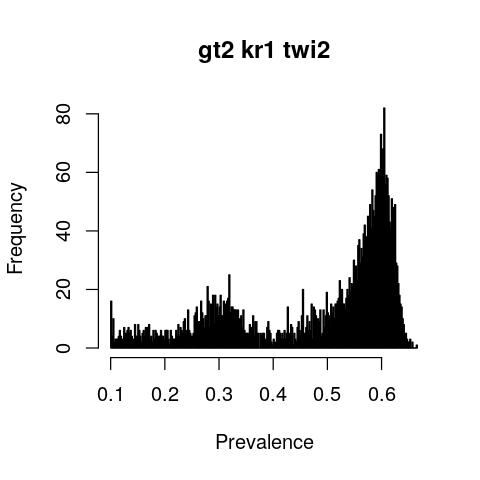

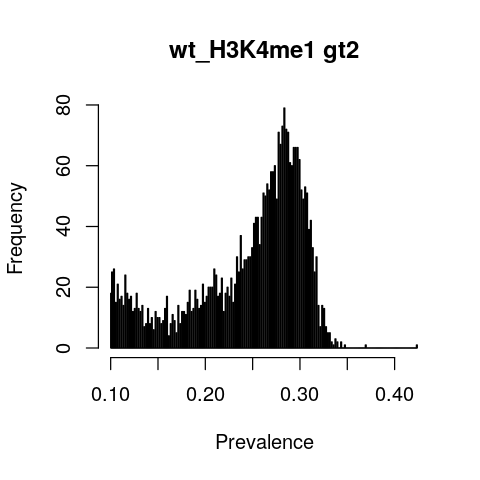

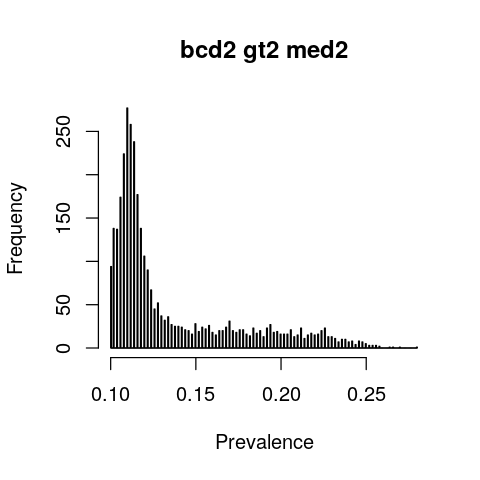

In [123]:
for (to_investigate in c('50 54', '45 79','45 78', '50 79', '54 64 79', '45 54', '48 54 67')) {
    hist(interaction.freq[[to_investigate]], main = index2names(to_investigate, varnames.all[[1]]), xlab = 'Prevalence', 300)
}

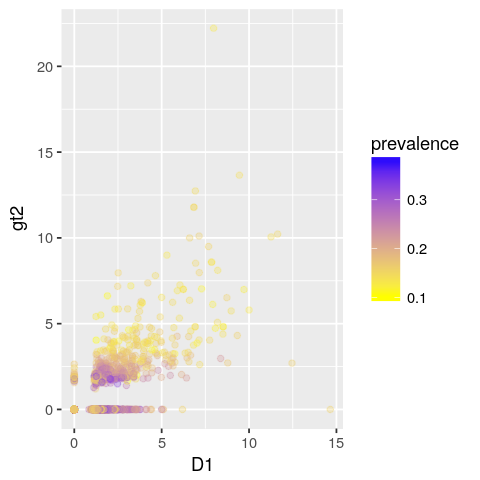

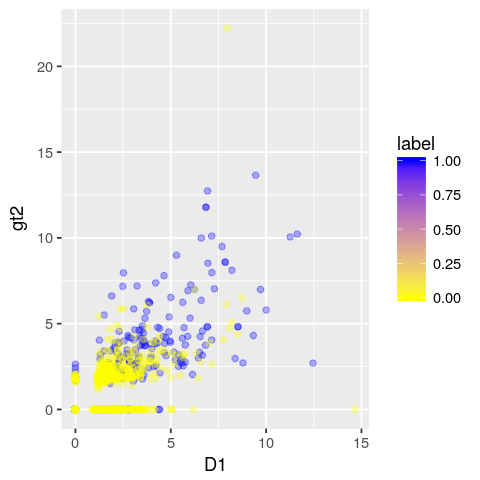

In [124]:
to_investigate = '50 54'
indices <- which(sapply(out.list, function(x) to_investigate %in% x$Interaction))
tmp <- interaction.freq[[to_investigate]] >= .4
group1 <- train.id[indices[tmp]]
group0 <- train.id[interaction.freq[[to_investigate]] < .4]
X1 <- X[group1,]
X0 <- X[group0,]
#plot(colMeans(X1))
#plot(colMeans(X0))
# mean difference over standard deviation
#plot((colMeans(X1) - colMeans(X0))/apply(X[train.id[indices],], 2, sd))
#which(colMeans(X1) - colMeans(X0) < -30)
ggplot(data = data.frame(D1 = X[train.id[indices],50], gt2 = X[train.id[indices],54], prevalence = interaction.freq[[to_investigate]])) +
    geom_point(aes(x = D1, y = gt2, colour = prevalence), alpha = .3)+scale_color_gradient(low="yellow", high="blue") 

ggplot(data = data.frame(D1 = X[train.id[indices],50], gt2 = X[train.id[indices],54], label = Y[train.id[indices]])) +
    geom_point(aes(x = D1, y = gt2, colour = label), alpha = .3)+scale_color_continuous(low="yellow", high="blue") 
